# Оцениваем регрессии на данных HS0 в спецификациях:
- Фиксированные эффекты ~ ковид и ограничения
- Фиксированные эффекты ~ ковид и ограничения | инструментальные переменные
- В перспективе: суммарный экспорт/импорт в зависимости от ковида (+ IV)

In [59]:
library(arrow)
library(stargazer)
library(tidyverse)
library(plotly)
library(fixest)

## Фиксированные эффекты

### Экспорт

+иллюстрирую, зачем тут нужны фиксированные эффекты

In [60]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_export_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C8EV_International_travel_controls,E1_Income_support,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2021,BMU,-4.7322695,BMU,2021,232.765781,4.10290411,NA,1.3397260,1.6410959,⋯,NA,NA,NA,BMU,2.26,34.09,48.39,15.81,2021,0
2020,FLK,-1.9501826,FLK,2020,22.791077,0.00000000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2020,0
2020,MAR,-4.6759347,MAR,2020,31.862597,0.53309392,NA,2.8961749,0.7759563,⋯,16.7,16.29101,21.93080,MAR,4.58,7.20,26.18,37.94,2020,0
2022,CRI,11.6705995,CRI,2022,319.252767,0.92893151,NA,0.2383562,0.0000000,⋯,7.2,34.43402,27.57339,CRI,3.21,12.07,48.80,31.61,2022,0
2021,SSD,0.7983226,SSD,2021,2.810219,0.01789041,NA,1.6520548,0.3260274,⋯,63.8,18.59871,NA,SSD,5.98,3.15,14.56,29.37,2021,0
2022,ISL,10.7069034,ISL,2022,1318.168356,1.07320548,NA,0.1890411,1.0520548,⋯,2.1,NA,NA,NA,NA,NA,NA,NA,2022,0


Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


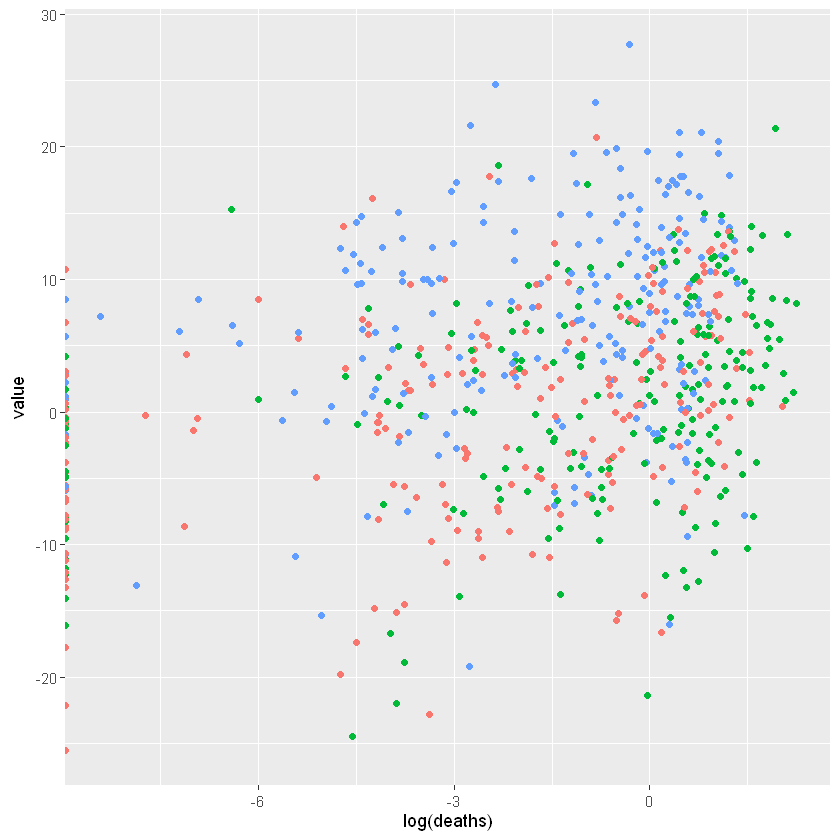

In [61]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p) 
p   

In [62]:
# Pulled OLS
m0 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
m0 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Newey-West (L=1) 
                                   Estimate Std. Error  t value Pr(>|t|)    
log(deaths)                        1.137831   0.257579 4.417409 0.047616 *  
C8EV_International_travel_controls 0.250616   0.723865 0.346219 0.762208    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.3561     Adj. R2: 0.207405
               Within R2: 0.091339

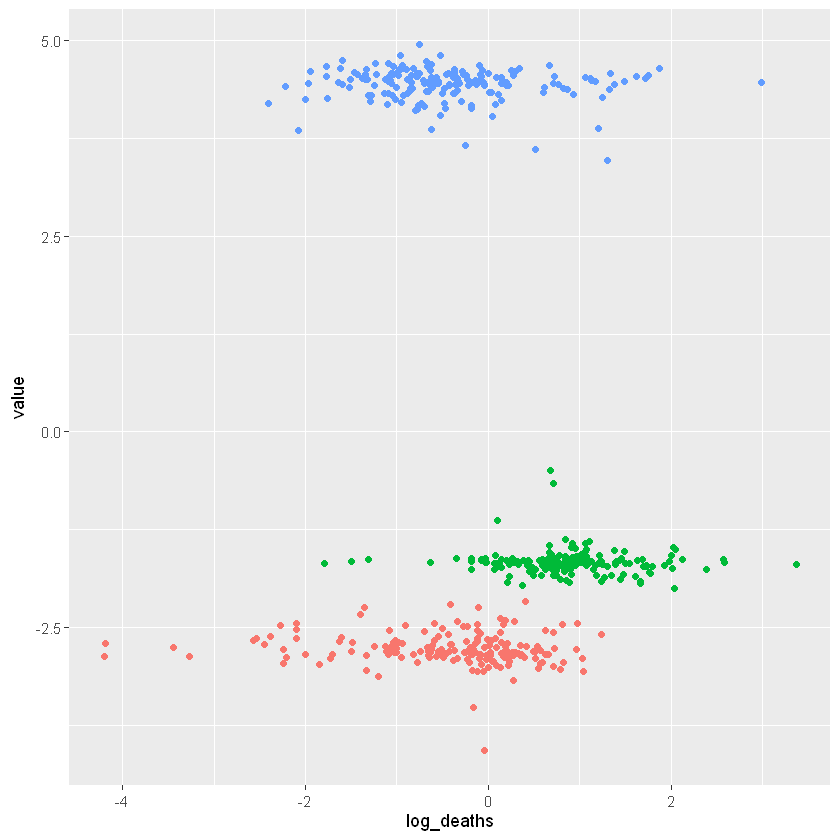

In [63]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

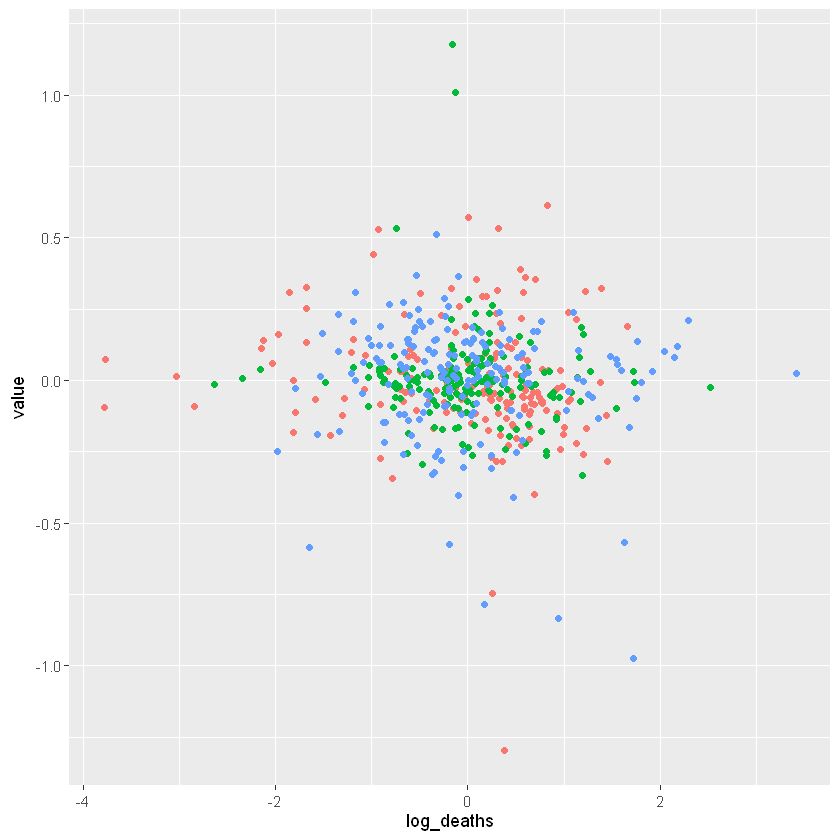

In [64]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)    
p

In [65]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,-2.772960,-0.4175810
2021,-1.664875,0.8439503
2022,4.437835,-0.4263693


In [66]:
m1 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
m1 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Newey-West (L=1) 
                                    Estimate Std. Error  t value Pr(>|t|) 
log(deaths)                        -0.011189   0.010691 -1.04660  0.40513 
C8EV_International_travel_controls -0.060563   0.031503 -1.92244  0.19448 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.164813     Adj. R2: 0.99939 
                 Within R2: 0.020382

In [67]:
# Маски сами по себе --- слабый инструмент
m1_iv = feols(value ~ 1 +
 C8EV_International_travel_controls|country + year|
 log(deaths) ~ H6M_Facial_Coverings,
 data = df)
m1_iv %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 126, IV: 74/126).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : H6M_Facial_Coverings
Second stage: Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Newey-West (L=1) 
                                    Estimate Std. Error   t value Pr(>|t|) 
fit_log(deaths)                    -0.190729   0.205056 -0.930134  0.45049 
C8EV_International_travel_controls -0.145438   0.108212 -1.344008  0.31111 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.221611     Adj. R2:  0.998898
                 Within R2: -0.771147
F-test (1st stage), log(deaths): stat = 3.39781, p = 0.065873, on 1 and 501 DoF.
                     Wu-Hausman: stat = 1.79629, p = 0.181095, on 1 and 326 DoF.

In [68]:
# Гетерогенность во времени
m2 = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
m2 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175
Standard-errors: Newey-West (L=1) 
                                             Estimate Std. Error   t value
year2021                                     1.022158   0.090863 11.249496
year2022                                     7.073336   0.098474 71.829604
year2020:log(deaths)                        -0.022881   0.011725 -1.951535
year2021:log(deaths)                        -0.016422   0.013781 -1.191635
year2022:log(deaths)                        -0.002128   0.013314 -0.159841
year2020:C8EV_International_travel_controls -0.091384   0.042403 -2.155120
year2021:C8EV_International_travel_controls -0.045326   0.035758 -1.267577
year2022:C8EV_International_travel_controls -0.029126   0.058403 -0.498711
                                              Pr(>|t|)    
year2021                                    0.00780950 ** 
year2022                                    0.00019376 ***
year2020:log(deaths)              

In [87]:
m3 = feols(value ~ 1 +
 C8EV_International_travel_controls| year|
 log(deaths) ~
 population_density + 
#  SARS_flg + # Почему-то он эндогенный с точки зрения Саргана
 H6M_Facial_Coverings +
#  share_1_members + # Добавляет пропуски
 median_age,
 data = df #%>% filter(year == '2020')
 )
m3 %>% summary(vcov = 'hc1')

NOTE: 154 observations removed because of NA and infinite values (RHS: 126, IV: 74/126).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : population_density, H6M_Facial_Coverings, median_age
Second stage: Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Heteroskedasticity-robust 
                                   Estimate Std. Error t value Pr(>|t|)    
fit_log(deaths)                    0.524703   0.246844 2.12565 0.034021 *  
C8EV_International_travel_controls 0.799780   0.581344 1.37574 0.169516    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.45501     Adj. R2:  0.150418
                Within R2: -0.006312
F-test (1st stage), log(deaths): stat = 146.6    , p < 2.2e-16, on 3 and 501 DoF.
                     Wu-Hausman: stat =   4.77197, p = 0.02939, on 1 and 500 DoF.
                         Sargan: stat =   0.99276, p = 0.60873, on 2 DoF.

In [70]:
etable(m0, m1, m2, m3)

,,m0,m1,m2,m3
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),1.138** (0.0571),-0.0112 (0.0108),,1.733** (0.1659)
4,C8EV_International_travel_controls,0.2506 (0.3831),-0.0606* (0.0286),,0.4206 (0.3100)
5,year2021,,,1.022*** (0.0883),
6,year2022,,,7.073*** (0.1018),
7,year2020 x log(deaths),,,-0.0229. (0.0120),
8,year2021 x log(deaths),,,-0.0164 (0.0124),
9,year2022 x log(deaths),,,-0.0021 (0.0137),


In [88]:
# Реплицирую (Berthou, 2024), но результат совсем не сходится...
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))
m %>% summary(vcov = 'twoway')

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.002699   0.001079 -2.50267  0.12939 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Clustered (country & year) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.002699   0.001205 -2.24076  0.15434 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

### Импорт

In [72]:
# Скачиваю данные и переназываю переменные
df = read_parquet('../data/processed_data/trade_hs0_import_fe_x_covid.parquet.gzip')
df = df %>% mutate(year = as.character(year), SARS_flg = as.integer(!is.na(SARS_total_cases)))
df %>% head()

year,country,value,country:r,t,cases,deaths,tests,C8EV_International_travel_controls,E1_Income_support,⋯,infant_mortality,largest_city_share,urbanization,country:household_size,avg_hh_size,share_1_members,share_2_3_members,share_4_5_members,year:r,SARS_flg
<chr>,<chr>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
2021,BMU,-3.3974488,BMU,2021,232.765781,4.10290411,NA,1.3397260,1.6410959,⋯,NA,NA,NA,BMU,2.26,34.09,48.39,15.81,2021,0
2020,FLK,-1.5572519,FLK,2020,22.791077,0.00000000,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,2020,0
2020,MAR,0.4427725,MAR,2020,31.862597,0.53309392,NA,2.8961749,0.7759563,⋯,16.7,16.29101,21.93080,MAR,4.58,7.20,26.18,37.94,2020,0
2022,CRI,-4.5786255,CRI,2022,319.252767,0.92893151,NA,0.2383562,0.0000000,⋯,7.2,34.43402,27.57339,CRI,3.21,12.07,48.80,31.61,2022,0
2021,SSD,1.4891466,SSD,2021,2.810219,0.01789041,NA,1.6520548,0.3260274,⋯,63.8,18.59871,NA,SSD,5.98,3.15,14.56,29.37,2021,0
2022,ISL,2.2191366,ISL,2022,1318.168356,1.07320548,NA,0.1890411,1.0520548,⋯,2.1,NA,NA,NA,NA,NA,NA,NA,2022,0


In [73]:
# Реплицирую (Berthou, 2024), но результат совсем не сходится...
m = feols(value ~ StringencyIndex_Average | country + year,
 data = df)
m %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 126 observations removed because of NA values (RHS: 126).



OLS estimation, Dep. Var.: value
Observations: 534
Fixed-effects: country: 178,  year: 3
Standard-errors: Newey-West (L=1) 
                         Estimate Std. Error  t value Pr(>|t|) 
StringencyIndex_Average -0.002699   0.001079 -2.50267  0.12939 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141099     Adj. R2: 0.999541
                 Within R2: 0.020914

In [74]:
demean(df[, c('deaths', 'value')], df[, c('country', 'year')]) %>% head()

NOTE: 6 observations removed because of NA values (Breakup: X: 6, f: 0).



deaths,value
<dbl>,<dbl>
1.2585530,0.01435228
0.3737463,-0.06643084
0.5067952,-0.20461955
-0.3781178,0.01006644
-0.6937078,0.06000947
0.9524571,0.07512482


Warning message:
"Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`)."


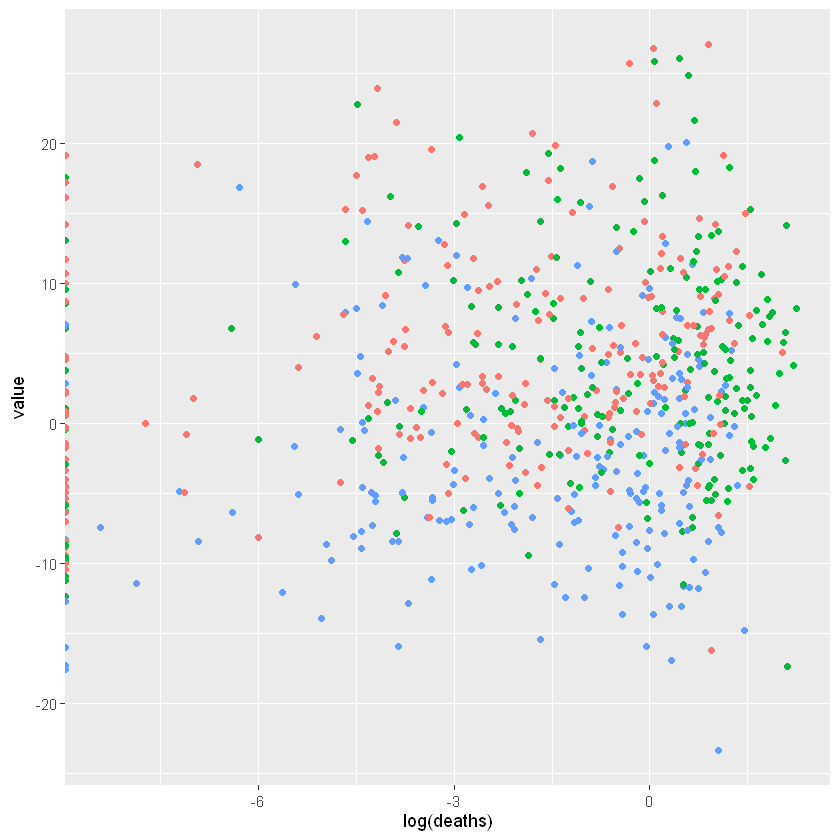

In [75]:
p = ggplot(df, aes(x = log(deaths), y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)   
p 

In [76]:
# Pulled OLS
m0 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| year,
 data = df)
m0 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Newey-West (L=1) 
                                   Estimate Std. Error  t value Pr(>|t|) 
log(deaths)                        0.149162   0.255517 0.583765  0.61844 
C8EV_International_travel_controls 0.692519   0.837481 0.826907  0.49524 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.41518     Adj. R2: 0.159473
                Within R2: 0.004412

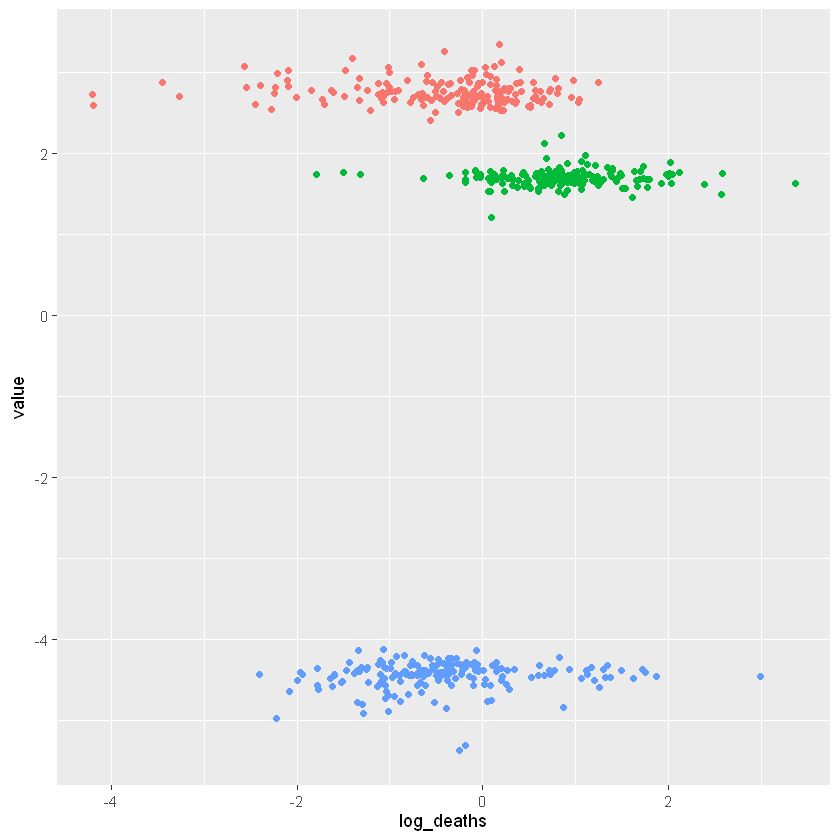

In [77]:
country_means_df = df %>% group_by(country) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log(deaths), na.rm = TRUE))  %>% filter(avg_log_deaths > -1000)

demeaned_df = df %>% merge(., country_means_df, by = 'country')  %>%
  mutate(log_deaths = log(deaths)- avg_log_deaths, value = value- avg_value) %>%
   select(country, year, log_deaths, value)
p = ggplot(demeaned_df, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()+ theme(legend.position = "none")
# ggplotly(p)  
p  

In [78]:
year_means_df

year,avg_value,avg_log_deaths
<chr>,<dbl>,<dbl>
2020,-2.772960,-0.4175810
2021,-1.664875,0.8439503
2022,4.437835,-0.4263693


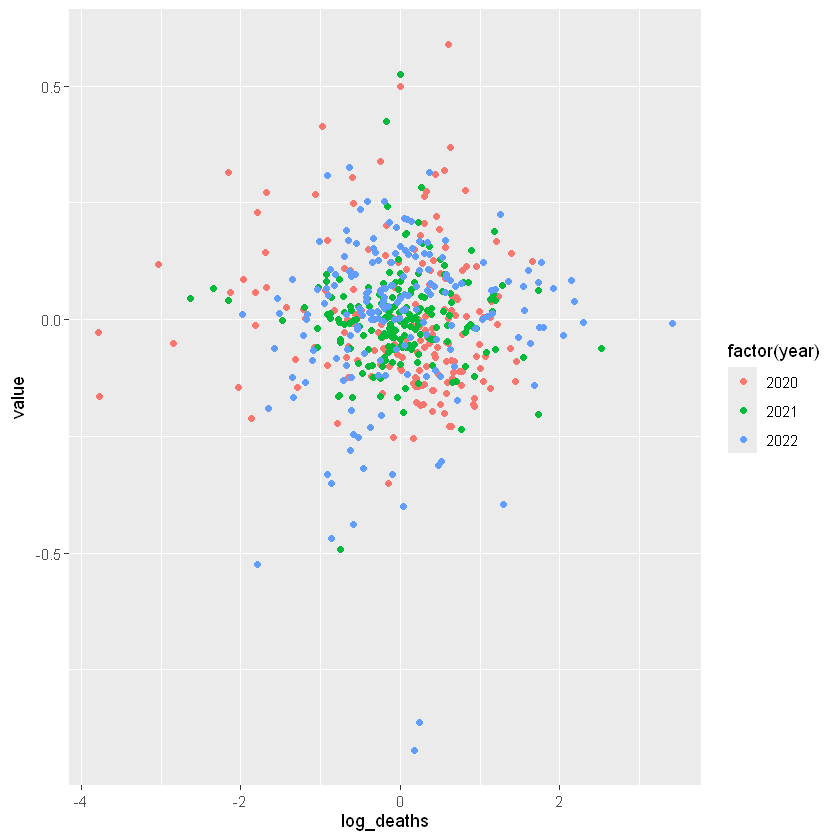

In [79]:
year_means_df = demeaned_df %>% filter(log_deaths > -5) %>% group_by(year) %>%
 summarize(avg_value = mean(value, na.rm = TRUE), avg_log_deaths = mean(log_deaths, na.rm = TRUE))

demeaned_df2 = demeaned_df %>% merge(., year_means_df, by = 'year')  %>%
  mutate(log_deaths = log_deaths- avg_log_deaths, value = value - avg_value) %>%
   select(country, year, log_deaths, value)

p = ggplot(demeaned_df2, aes(x = log_deaths, y = value, text = factor(country), color = factor(year)
    )) + geom_point()#+ theme(legend.position = "none")
# ggplotly(p)   
p 

In [80]:
m1 = feols(value ~ log(deaths) +
 C8EV_International_travel_controls| country + year,
 data = df)
m1 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Newey-West (L=1) 
                                    Estimate Std. Error   t value Pr(>|t|) 
log(deaths)                        -0.001126   0.008728 -0.129015  0.90915 
C8EV_International_travel_controls -0.032537   0.023079 -1.409800  0.29400 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.141505     Adj. R2: 0.999531
                 Within R2: 0.008014

In [81]:
# Маски сами по себе --- слабый инструмент
m1_iv = feols(value ~ 1 +
 C8EV_International_travel_controls|country + year|
 log(deaths) ~ H6M_Facial_Coverings,
 data = df)
m1_iv %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 126, IV: 74/126).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : H6M_Facial_Coverings
Second stage: Dep. Var.: value
Observations: 506
Fixed-effects: country: 175,  year: 3
Standard-errors: Newey-West (L=1) 
                                    Estimate Std. Error  t value Pr(>|t|) 
fit_log(deaths)                    -0.354424   0.302017 -1.17352  0.36142 
C8EV_International_travel_controls -0.199554   0.154980 -1.28761  0.32677 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 0.324054     Adj. R2: 0.997541
                 Within R2: -4.20231
F-test (1st stage), log(deaths): stat = 3.39781, p = 0.065873, on 1 and 501 DoF.
                     Wu-Hausman: stat = 9.66215, p = 0.002047, on 1 and 326 DoF.

In [82]:
# Гетерогенность во времени
m2 = feols(value ~ year/log(deaths) + year/C8EV_International_travel_controls| country,
 data = df)
m2 %>% summary(vcov = vcov_NW(unit = 'country', time = 'year'))

NOTE: 154 observations removed because of NA and infinite values (RHS: 154).



OLS estimation, Dep. Var.: value
Observations: 506
Fixed-effects: country: 175
Standard-errors: Newey-West (L=1) 
                                             Estimate Std. Error    t value
year2021                                    -1.126174   0.080969 -13.908692
year2022                                    -7.154620   0.092792 -77.103871
year2020:log(deaths)                        -0.020088   0.010316  -1.947238
year2021:log(deaths)                         0.005541   0.011398   0.486103
year2022:log(deaths)                         0.015720   0.010989   1.430566
year2020:C8EV_International_travel_controls -0.030939   0.034473  -0.897481
year2021:C8EV_International_travel_controls  0.009248   0.022288   0.414945
year2022:C8EV_International_travel_controls -0.090944   0.075706  -1.201273
                                              Pr(>|t|)    
year2021                                    0.00512951 ** 
year2022                                    0.00016817 ***
year2020:log(deaths)     

In [83]:
m3 = feols(value ~ 1 +
 C8EV_International_travel_controls| year|
 log(deaths) ~
 population_density + 
#  SARS_flg + # Почему-то он эндогенный с точки зрения Саргана
 H6M_Facial_Coverings +
#  share_1_members + # Добавляет пропуски
 median_age,
 data = df #%>% filter(year == '2020')
 )
m3 %>% summary(vcov = 'hc1')

NOTE: 154 observations removed because of NA and infinite values (RHS: 126, IV: 74/126).



TSLS estimation - Dep. Var.: value
                  Endo.    : log(deaths)
                  Instr.   : population_density, H6M_Facial_Coverings, median_age
Second stage: Dep. Var.: value
Observations: 506
Fixed-effects: year: 3
Standard-errors: Heteroskedasticity-robust 
                                   Estimate Std. Error t value Pr(>|t|)    
fit_log(deaths)                    0.524703   0.246844 2.12565 0.034021 *  
C8EV_International_travel_controls 0.799780   0.581344 1.37574 0.169516    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
RMSE: 7.45501     Adj. R2:  0.150418
                Within R2: -0.006312
F-test (1st stage), log(deaths): stat = 146.6    , p < 2.2e-16, on 3 and 501 DoF.
                     Wu-Hausman: stat =   4.77197, p = 0.02939, on 1 and 500 DoF.
                         Sargan: stat =   0.99276, p = 0.60873, on 2 DoF.

In [84]:
etable(m0, m1, m2, m3)

,,m0,m1,m2,m3
,<chr>,<chr>,<chr>,<chr>,<chr>
1,Dependent Var.:,value,value,value,value
2,,,,,
3,log(deaths),0.1492 (0.1172),-0.0011 (0.0087),,0.5247*** (0.0089)
4,C8EV_International_travel_controls,0.6925. (0.1802),-0.0325 (0.0208),,0.7998* (0.0894)
5,year2021,,,-1.126*** (0.0807),
6,year2022,,,-7.155*** (0.0987),
7,year2020 x log(deaths),,,-0.0201. (0.0107),
8,year2021 x log(deaths),,,0.0055 (0.0105),
9,year2022 x log(deaths),,,0.0157 (0.0111),


## Суммарный экспорт/импорт